# **Line search Newton-CG method**

Line searh Newton-CG is a type of inexact Newton method, all this method are designed to optimize an objective function $J : \mathbb{R}^n \longrightarrow \mathbb{R}$ of second
order $C^2$, where the dimension $n$ is big enough to consider the minimization problem a large-scale problem. 

The convergence of inexact Newton methods requires an additional property over the gradient of the function $J$ at each iteration $k \in \mathbb{N}$ of the algorithm we must satisfy
the following bound inequality relating the gradient $\nabla f_k$, the Hessian $\nabla^2 f_k$ and the descent direction $p_k$.
\begin{equation}
\left\| \nabla^2 f_k p_k + \nabla f_k \right\| \leq \eta_k \left\| f_k \right\|
\end{equation}
where the ***forcing sequence*** satisfies $0 < \eta_k < 1$

**Theorem**[ 7.1 Nocedal y Wright] Suppose that $\nabla^2 f(x)$ exists and its continuous in a neighborhood of a minimizer $x^*$ with 

In [1]:
import numpy as np
from scipy import sparse as sp
from scipy import linalg as la
from matplotlib import cm
from matplotlib import pyplot as plt

---
## **Line search with strong Wolfe conditions**
The line-search method is designed to satisfy the strong Wolfe conditions
\begin{eqnarray}
f(x_k + \alpha_k p_k ) & \leq & 
f(x_k) + c_1 \alpha_k \left\langle \nabla f( x_k )\ \middle|\ p_k \right\rangle \\
\left| \left\langle \nabla f( x_k + \alpha_k p_k )\ \middle|\ p_k \right\rangle \right| & \leq & 
c_2 \left| \left\langle \nabla f( x_k )\ \middle|\ p_k \right\rangle \right|
\end{eqnarray}
with $0 < c_1 < c_2 < 1$

In [2]:
def line_search_wolfe( x, a, p, f, g, c1, c2, m ) :
  alpha_min = 0
  alpha = a
  alpha_max = np.inf

  fx = f( x )
  gx = g( x )
  hx = gx.dot( p )

  z = x + alpha * p
  fz = f( z )
  gz = g( z )
  hz = gz.dot( p ) 

  W1 = fx + alpha * c1 * hx
  W2 = c2 * hx
  i = 0
  while ( ( fz > W1 or hz < W2 ) and i < m ) :
    if fz > W1:
      alpha_max = alpha
      alpha = 0.5 * ( alpha_min + alpha_max )

    elif hz < W2 :
      if alpha_max >= np.inf :
        alpha = 2 * alpha
      else :
        alpha_min = alpha
        alpha = 0.5 * ( alpha_min + alpha_max )

    z = x + alpha * p
    fz = f( z )
    gz = g( z )
    hz = gz.dot( p )
    i = i + 1

  chk = fz > W1 or hz < W2

  return ( alpha, i, chk )

## **Line search with strong Wolfe conditions adapted to satisfy the convergence conditions of the inexact Newton method**
Adaptation of line search algortihm to satisfy the condition $\left\| \nabla^2 f_k p_k + \nabla f_k \right\| \leq \eta_k \left\| f_k \right\|$
we note that the tentave next optimal value will be $x_{k+1} = x_k + \alpha_k p_k$
\begin{eqnarray}
f_{k+1}
& \leq & f_k + c_1 \alpha_k \left\langle \nabla f_k\ \middle|\ p_k \right\rangle \\
\frac{1}{|\alpha_k|} \left| \left\langle \nabla^2 f_k ( \alpha_k p_k ) + \nabla f_k\ \middle|\ \alpha_k p_k \right\rangle \right| 
& \leq & c_2 \left| \left\langle \nabla f_k\ \middle|\ p_k \right\rangle \right|
\end{eqnarray}
with $0 < c_1 < c_2 < 1$

In [3]:
def line_search_wolfe_2( x, a, p, f, g, h, c1, c2, m ) :
  alpha_min = 0
  alpha = a
  alpha_max = np.inf

  fx = f( x )
  gx = g( x )
  hx = gx.dot( p )

  z = x + alpha * p
  fz = f( z )
  gz = g( z )
  hz = gz.dot( p ) 

  W1 = fx + alpha * c1 * hx
  W2 = c2 * hx
  i = 0
  while ( ( fz > W1 or hz < W2 ) and i < m ) :
    if fz > W1:
      alpha_max = alpha
      alpha = 0.5 * ( alpha_min + alpha_max )

    elif hz < W2 :
      if alpha_max >= np.inf :
        alpha = 2 * alpha
      else :
        alpha_min = alpha
        alpha = 0.5 * ( alpha_min + alpha_max )

    z = x + alpha * p
    fz = f( z )
    gz = g( z )

    q = alpha * p
    # Change to satisfy the condition (7.3) de Nocedal y Wright
    hz = ( h( z ).dot( q ) + gz ).dot( q ) / np.abs( alpha )
    i = i + 1

  chk = fz > W1 or hz < W2

  return ( alpha, i, chk )

---
## **Implementation of the line search Newton-CG**
The line search Newton-CG algorithm modified to select the line search method

In [4]:
def ls_newton_cg( x, J, dJ, d2J, N, M, c1, c2, lsi, lsi_sel, err ) :

  F = []
  G = []
  ng = 2 * err
  k = 0

  while k < N and ng > err:
    alpha = 0
    z = 0
    g = dJ( x )
    ng = la.norm( g )

    F.append( J( x ) )
    G.append( ng )

    r = g
    B = d2J( x )
    d = -r
    e = np.min( [ 0.5, np.sqrt( la.norm( r ) ) ] ) * la.norm( r )

    j = 0
    while j < M :
      kappa = d.T.dot( B.dot( d ) )
      if kappa <= 0 :
        if j == 0 :
          p = -g
          break
        else :
          p = z
          break

      alpha = r.dot( r ) / kappa
      z = z + alpha * d
      r0 = r
      r = r + alpha * B.dot( d )
      if la.norm( r ) < e:
        p = z
        break
      e = np.min( [ 0.5, np.sqrt( la.norm( g ) ) ] ) * la.norm( g )

      beta = r.dot( r ) / r0.dot( r0 )
      d = -r + beta * d
      j = j + 1

    if lsi_sel == 1:
      [ alpha, i, chk ] = line_search_wolfe( x, alpha, p, J, dJ, c1, c2, lsi )
    elif lsi_sel == 2 :
      [ alpha, i, chk ] = line_search_wolfe_2( x, alpha, p, J, dJ, d2J, c1, c2, lsi )
    
    x = x + alpha * p
    k = k + 1
    
  return [ x, g, F, G, k ]

---
### **1. Example** 
We consider the classical regression problem with the objective function given byregressionregression
\begin{equation}
J(x) = \frac{1}{2} \| Ax - b \|^2
\end{equation}

the gradient of $J$
\begin{equation}
\nabla J( x ) = A^T( A x - b )
\end{equation}

the Hessian of $J$
\begin{equation}
\nabla^2 J(x) = A^T A 
\end{equation}

In [5]:
m = 1000
n = 5
A = np.random.normal( 10, 5, ( m, n ) )
b = np.random.normal( 0, 5, m )

def J( x ) :
  global A, b, alpha, D
  Jx = 0.5 * la.norm( A.dot( x ) - b )**2
  return Jx

K = A.T.dot( A )
c = A.T.dot( b )

def dJ( x ) :
  global K, c, alpha, D
  g = K.dot( x ) - c   
  return g

def d2J( x ) :
  global K
  return K

In [12]:
N = 10000
M = 5
err = 1e-10

c1 = 0.0001
c2 = 0.01
lsi = 10
lsi_sel = 2
x = np.random.normal( 0, 2, n )

[ x, g, F, G, k ] = ls_newton_cg( x, J, dJ, d2J, N, M, c1, c2, lsi, lsi_sel, err )
print( k )
print( x )
print( F[-1] )
print( G[-1] )

1308
[-0.0080362   0.0465442  -0.00358167 -0.03899484  0.009113  ]
12732.851764073934
9.713677116398482e-11


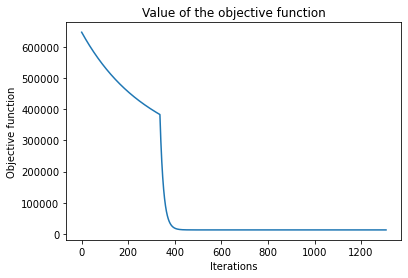

In [13]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Objective function' )
plt.title( 'Value of the objective function' )
plt.plot( F )

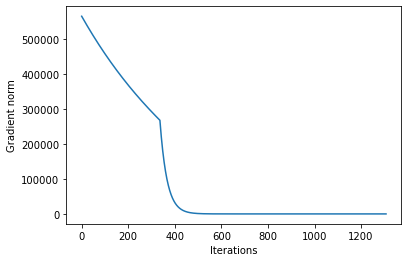

In [14]:
plt.xlabel( 'Iterations' )
plt.ylabel( 'Gradient norm' )
# plt.xscale( 'log' )
# plt.yscale( 'log' )
plt.plot( G )

---
### **2. Example** 